In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import cv2 as cv
import os

import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
import numpy as np

In [53]:



@torch.no_grad()
def get_features(model, dataloader, device='cuda', n_augments=1):
    model.to(device)
    labels = []
    features = None
    for aug in range(n_augments):
        for idx, (x, y) in enumerate(dataloader):

            f = model(x.to(device))
            if features is None:
                features = torch.empty(
                    (0, f.shape[1]), dtype=torch.float32, device=device)
            features = torch.cat((features, f))
            labels += y

    return features.cpu(), labels


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, color_augs=None):
        self.transforms = transforms
        self.color_augs = color_augs

        self.images = []
        self.labels = []

        for (root, dirs, fs) in os.walk(root):
            for f in fs:
                if not f.endswith('png'):
                    continue

                self.images.append(root + '/' + f)
                self.labels.append(root.split('/')[-1])

        print(f'init complete, found {len(self.images)} objects')

    def __getitem__(self, ix):

        image = cv.imread(self.images[ix])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # mask = cv.inRange(image, (1, 1, 1), (255, 255, 255))

        mask = (image != (0, 0, 0))[:, :, 0].astype(np.uint8)
        # mask[mask != 0] = 255

        # plt.imshow(mask)
        # plt.show()



        mask = cv.morphologyEx(mask.astype(np.uint8), cv.MORPH_ERODE, np.ones(
            (3, 3), np.uint8)).astype(np.uint8)

        cntrs, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        if len(cntrs) > 1:
            areas = np.array([cv.contourArea(c) for c in cntrs])
            biggest_cntr = cntrs[np.argmax(areas)]
            new_mask = np.zeros_like(mask)
            cv.drawContours(new_mask, [biggest_cntr], -1, 255, cv.FILLED)
            mask = new_mask

        if self.color_augs is not None:
            image = self.color_augs(image=image)['image']

        image = cv.bitwise_and(image, image, mask=mask)
        label = self.labels[ix]

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        return image, label

    def __len__(self):
        return len(self.labels)



init complete, found 28 objects


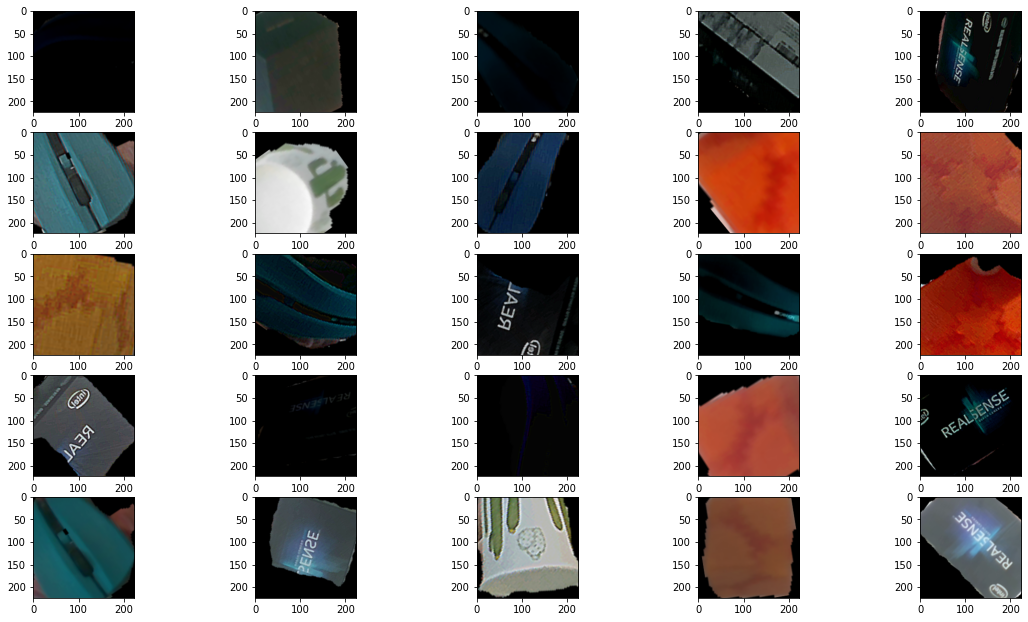

In [60]:

fe_augmentations = A.Compose([
    A.LongestMaxSize(max_size=300),
    A.PadIfNeeded(min_height=300, min_width=300,
                  border_mode=cv.BORDER_CONSTANT, p=1),
    A.Flip(),
    A.ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2,


    
                       rotate_limit=90, border_mode=cv.BORDER_CONSTANT, p=1),
    A.CenterCrop(224, 224, p=1.0),
])
color_augs = A.Compose([
    A.RandomBrightnessContrast(
        brightness_limit=0.3, contrast_limit=0.4, p=1),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=20, p=1),
    A.Sharpen(alpha=(0.3, 0.8), p=0.6),
])

# dataset = MyDataset('cropped_objects_uniques', transforms=fe_augmentations)
dataset = MyDataset('segmentation_dataset_m_platform',
                    transforms=fe_augmentations, color_augs=color_augs)

fig, axs = plt.subplots(5, 5, figsize=(19.2, 10.8))

indxs = np.random.randint(0, len(dataset), size=25)

for i in range(5):
    for j in range(5):
        im = dataset.__getitem__(indxs[j + i * 5])[0]
        axs[i, j].imshow(im)
plt.show()

In [25]:
im[100]

array([[134,  47,   7],
       [134,  46,   7],
       [134,  46,   7],
       [134,  46,   7],
       [133,  46,   6],
       [133,  46,   6],
       [133,  46,   6],
       [133,  46,   6],
       [134,  46,   6],
       [134,  46,   7],
       [134,  46,   7],
       [134,  46,   6],
       [134,  45,   6],
       [134,  45,   6],
       [133,  45,   6],
       [134,  45,   6],
       [134,  45,   5],
       [134,  45,   3],
       [131,  44,   1],
       [ 89,  29,   1],
       [ 45,  15,   0],
       [ 13,   4,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0